In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

pd.set_option("mode.copy_on_write", True)
import seaborn.objects as so
from matplotlib import style
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
import seaborn as sns

sns.set(rc={"figure.dpi": 300, "savefig.dpi": 300})

repo_root = "../.."
# source files
scoped = repo_root + "/20_intermediate_file/overdose_analysis_scope_{}.parquet"

# output files
res_dir = Path(repo_root + "/30_results/overdose")

percap = "Deaths per 100k Population"

In [2]:
change_years = {"Texas": 2007, "Florida": 2010, "Washington": 2012}

In [3]:
def pre(overdose, state, change_year):
    overdose = overdose[overdose["STNAME"] == state]
    overdose = overdose[overdose["Year"] < change_year]

    ax = sns.regplot(overdose, x="Year", y=percap, ci=68, scatter=False, label=state)
    ax.set_title(f"{state} Pre-{change_year} Overdose deaths Model Graph")
    plt.legend()

In [4]:
tx_df = pd.read_parquet(scoped.format("Texas"))
fl_df = pd.read_parquet(scoped.format("Florida"))
wa_df = pd.read_parquet(scoped.format("Washington"))

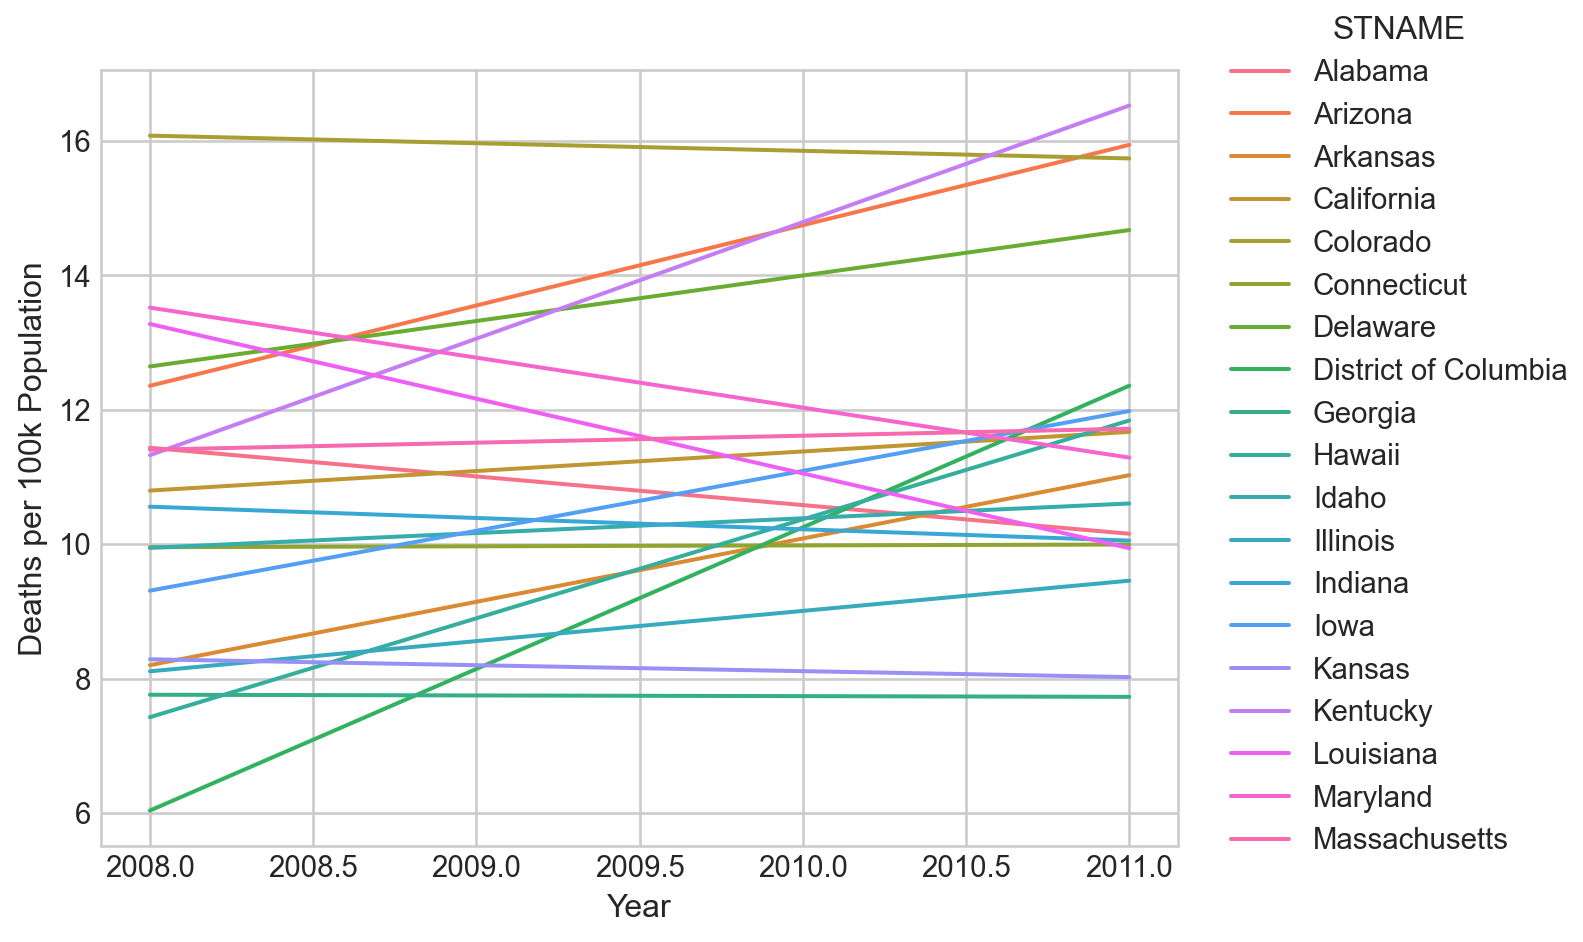

In [5]:
state = "Washington"
overdose = wa_df

states = overdose["STNAME"].unique()
states1 = states[: len(states) // 2]
states2 = states[len(states) // 2 :]

(
    so.Plot(
        overdose[
            (overdose.Year < change_years[state]) & (overdose.STNAME.isin(states1))
        ],
        x="Year",
        y=percap,
        color="STNAME",
    )
    .add(so.Line(), so.PolyFit(1))
    .label(title="")
    .theme({**style.library["seaborn-v0_8-whitegrid"]})
)

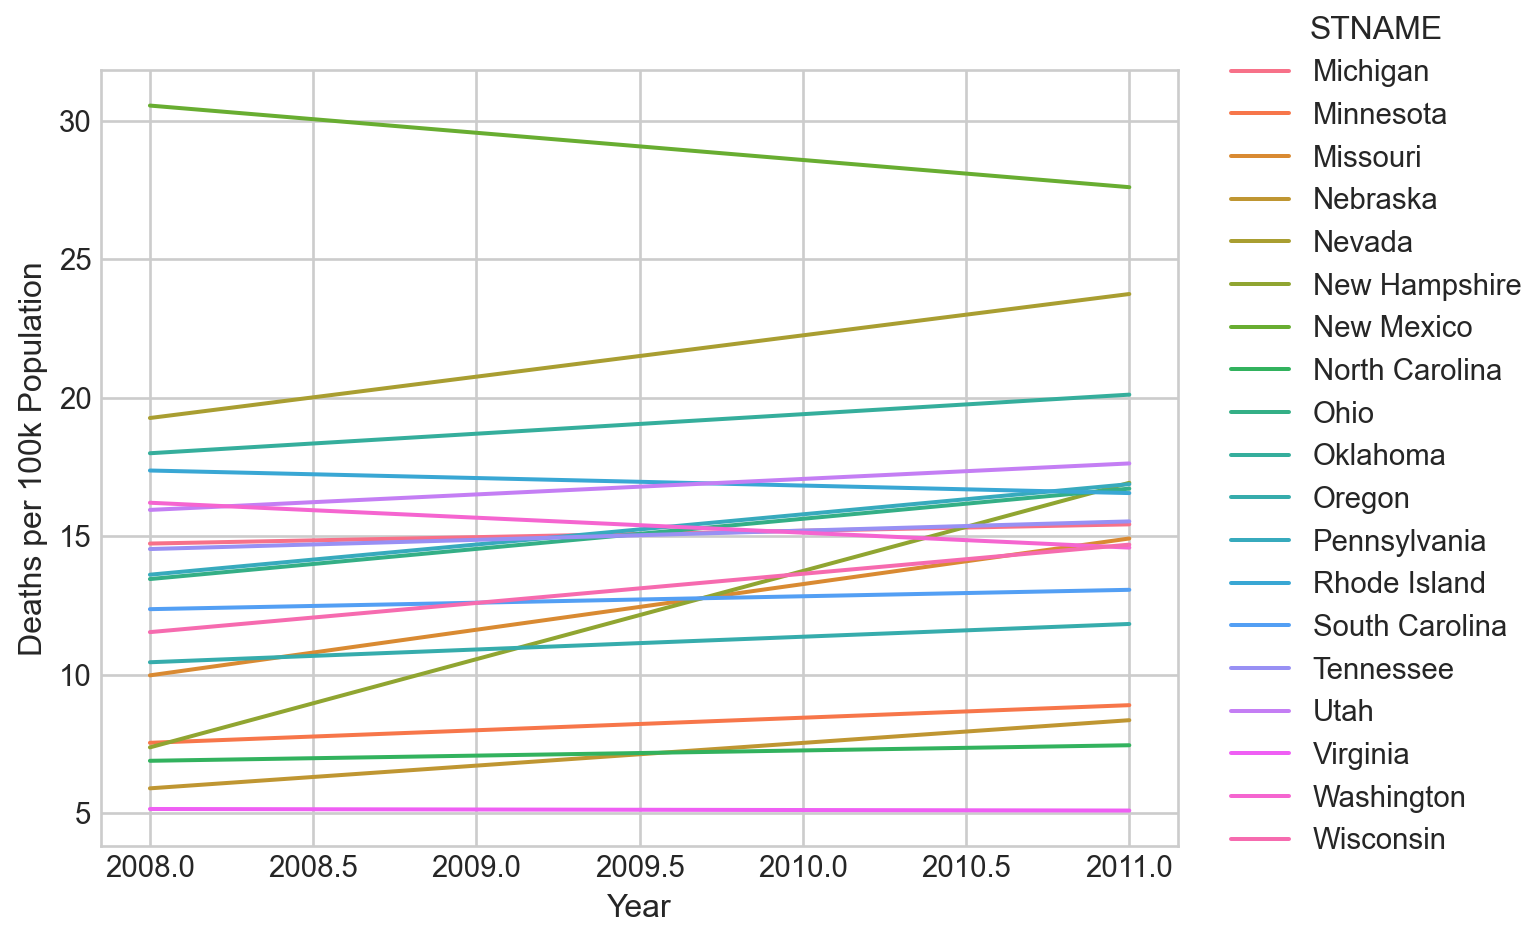

In [6]:
(
    so.Plot(
        overdose[
            (overdose.Year < change_years[state]) & (overdose.STNAME.isin(states2))
        ],
        x="Year",
        y=percap,
        color="STNAME",
    )
    .add(so.Line(), so.PolyFit(1))
    .label(title="")
    .theme({**style.library["seaborn-v0_8-whitegrid"]})
)

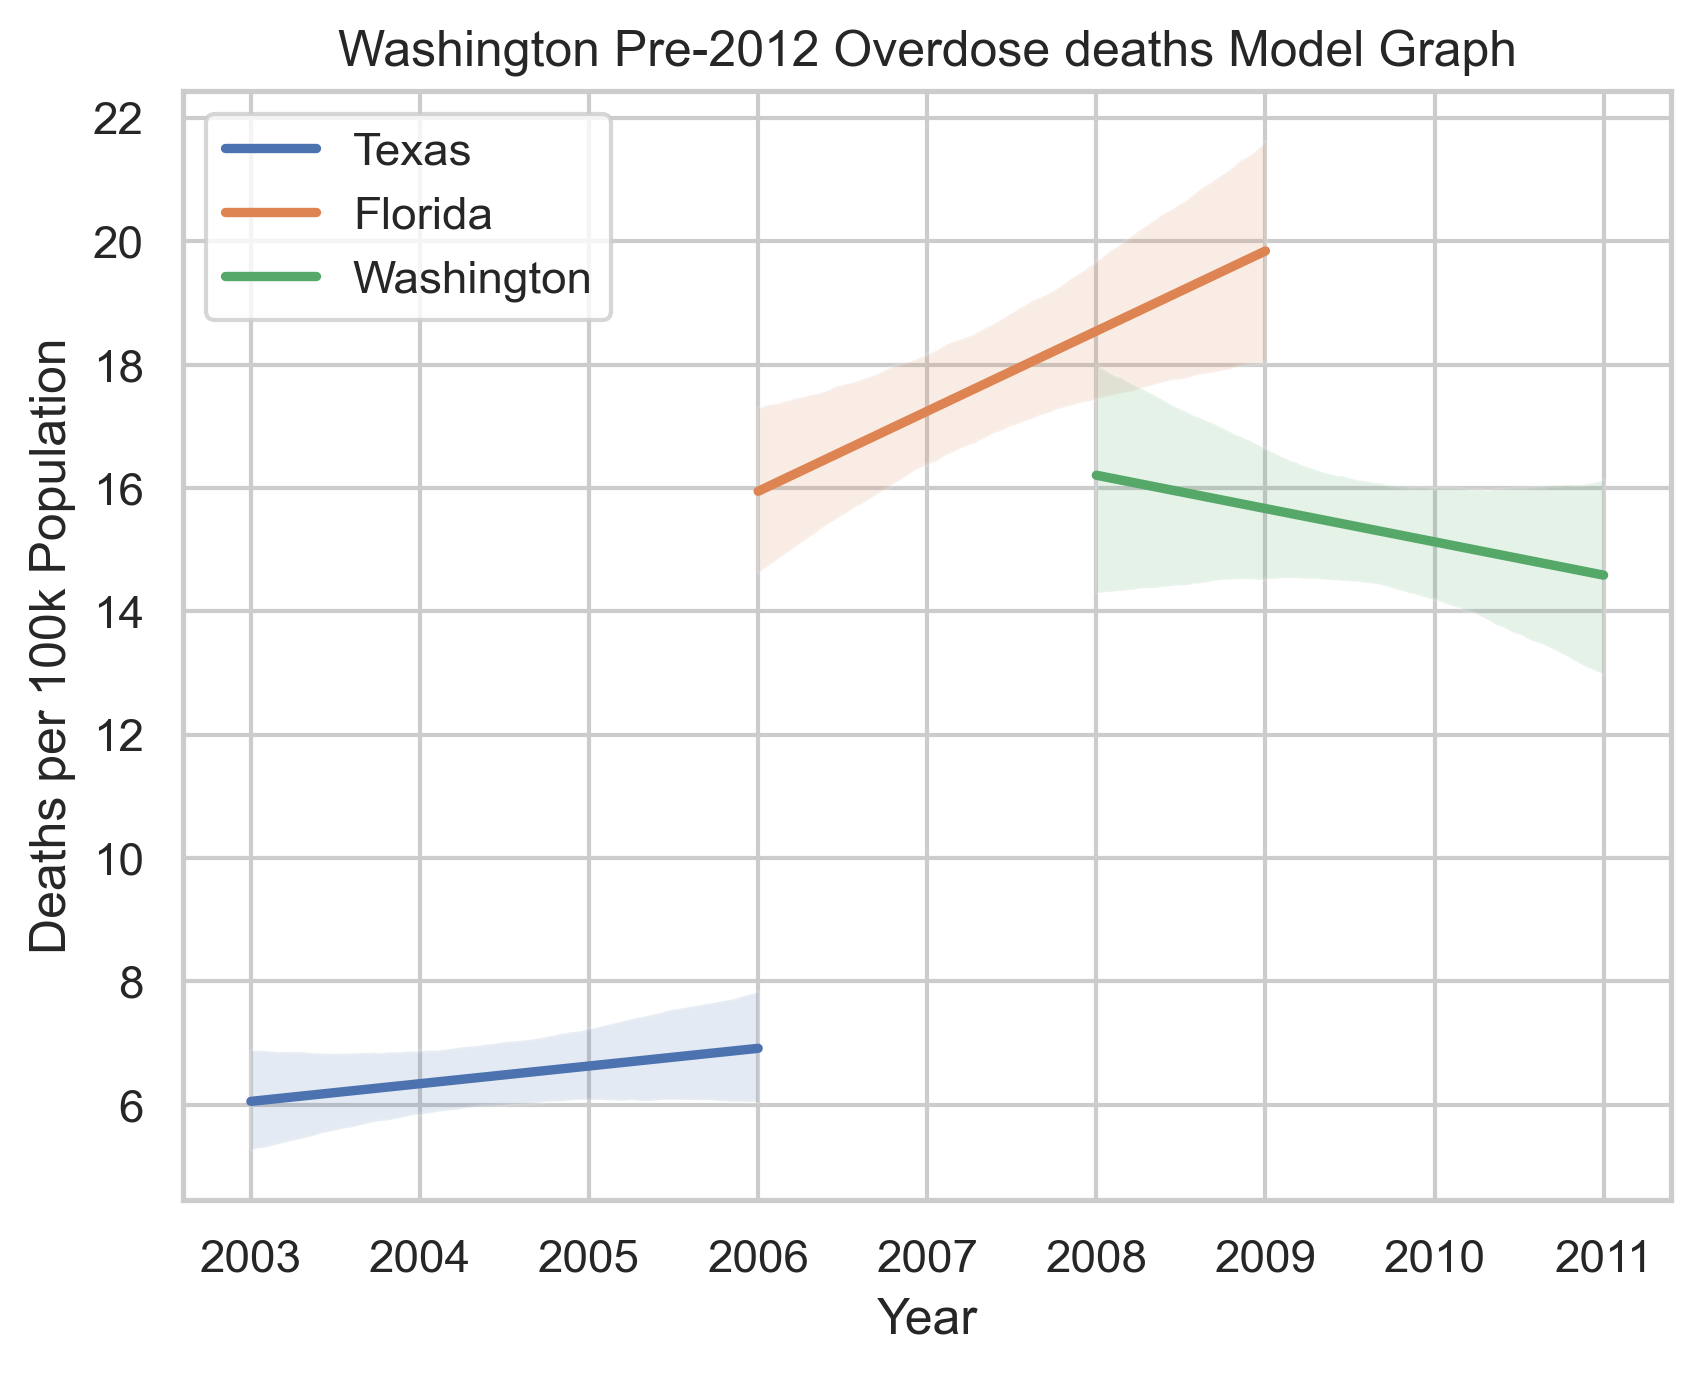

In [7]:
sns.set_style("whitegrid")
pre(tx_df, "Texas", 2007)
pre(fl_df, "Florida", 2010)
pre(wa_df, "Washington", 2012)

In [8]:
def diff_in_diff(overdose, state, controls):
    state_df = overdose[overdose["STNAME"].isin(controls + [state])]
    state_df[state] = state_df["STNAME"] == state
    state_df["Year"] -= change_years[state]

    plt.figure(figsize=(9, 6))
    ax = sns.regplot(
        state_df[(state_df[state]) & (state_df.Year >= 0)],
        x="Year",
        y=percap,
        color=sns.color_palette()[0],
        scatter=False,
        ci=68,
    )
    ax.text(0, ax.get_ylim()[1] - 2, "Policy Change", ha="right")
    sns.regplot(
        state_df[(state_df[state]) & (state_df.Year < 0)],
        x="Year",
        y=percap,
        color=sns.color_palette()[0],
        scatter=False,
        ci=68,
        label=state,
    )
    sns.regplot(
        state_df[(~state_df[state]) & (state_df.Year >= 0)],
        x="Year",
        y=percap,
        color=sns.color_palette()[1],
        scatter=False,
        ci=68,
    )
    sns.regplot(
        state_df[(~state_df[state]) & (state_df.Year < 0)],
        x="Year",
        y=percap,
        color=sns.color_palette()[1],
        scatter=False,
        ci=68,
        label=", ".join(controls),
    )

    ax.set_title(f"{state} Overdose Deaths Diff-in-diff Model Graph")
    ax.set_xlabel("Years from Policy Change")
    ax.axvline(0, color="grey", linestyle="--")

    ax.legend()
    plt.tight_layout()
    plt.savefig(res_dir / f"{state}_Overdose_Diff-in-diff")

# Texas

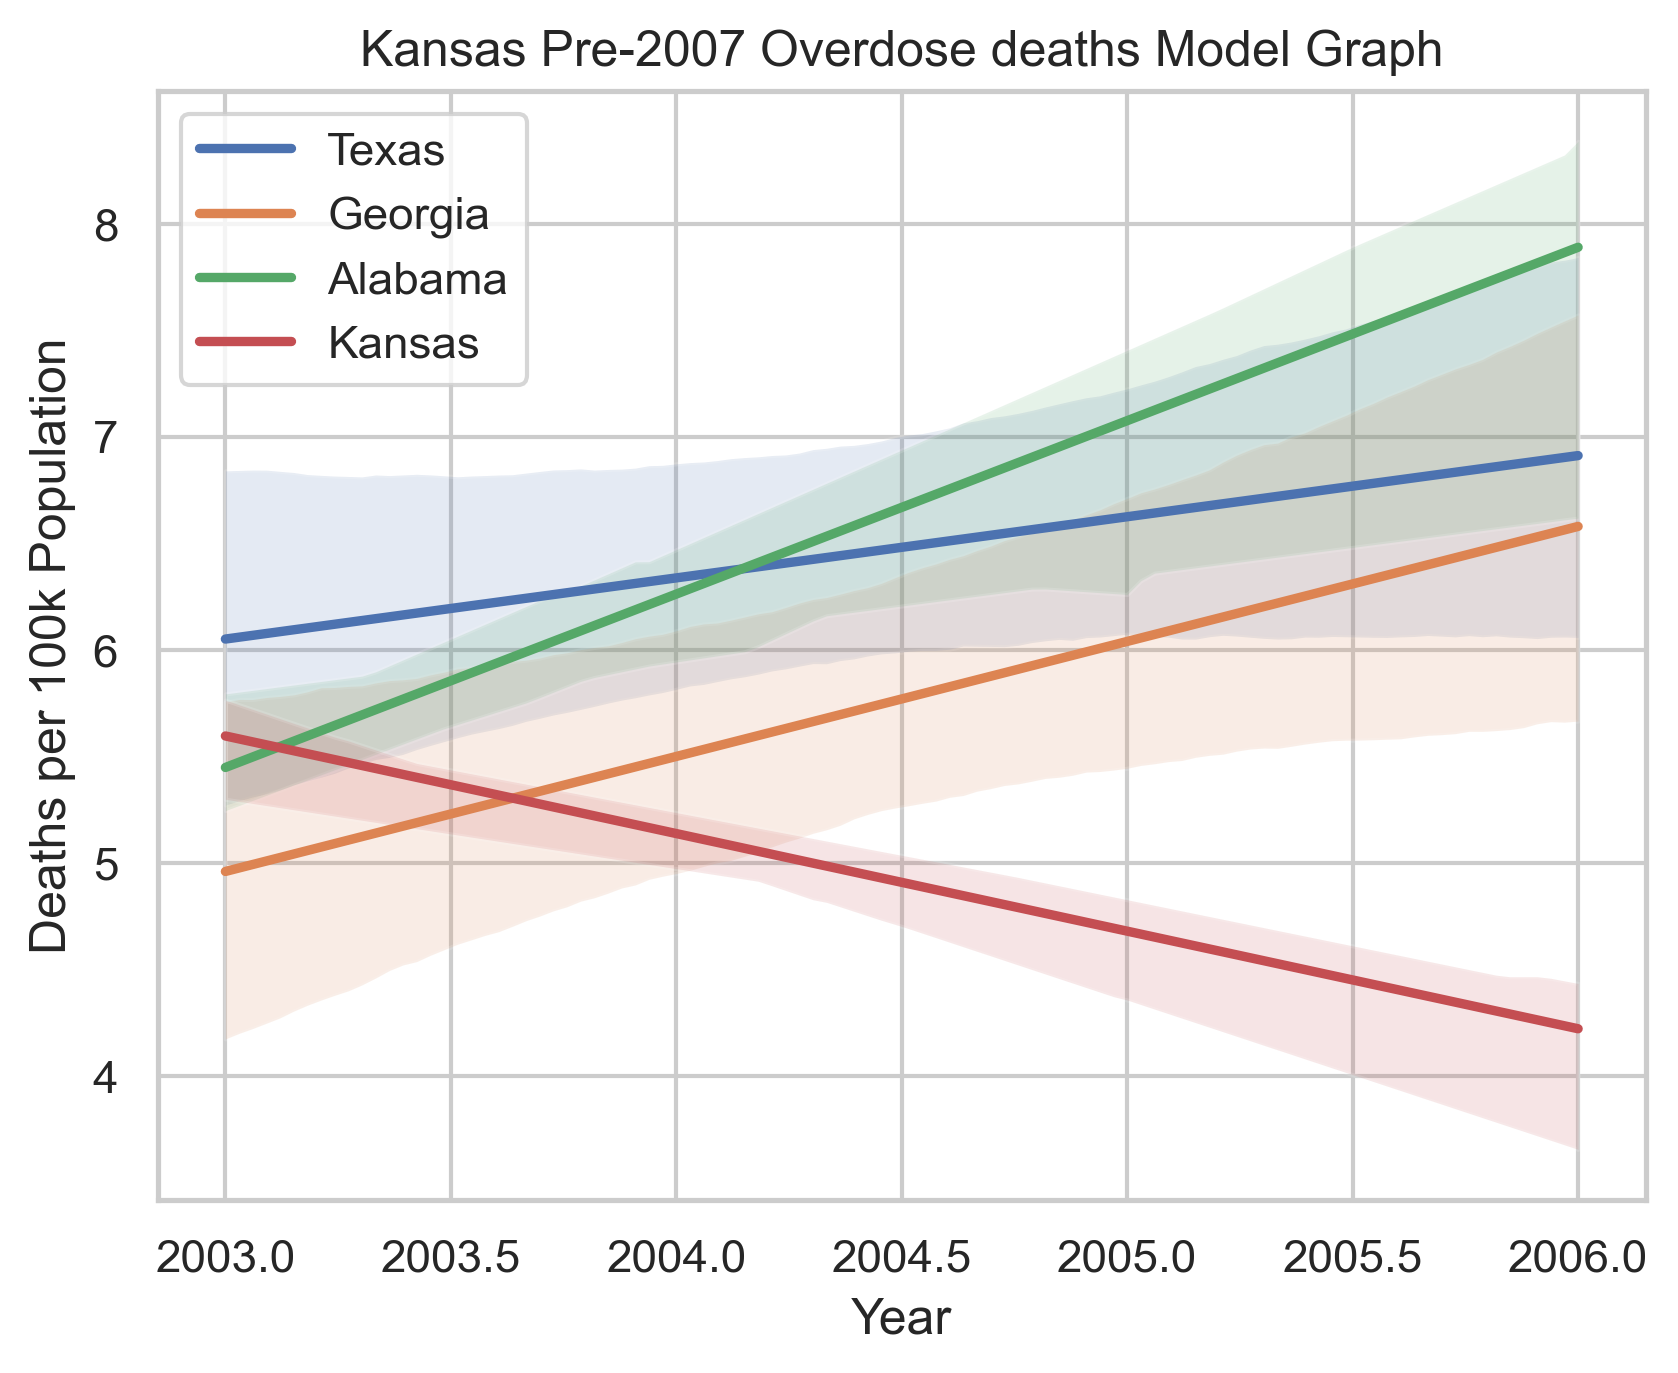

In [9]:
pre(tx_df, "Texas", 2007)
pre(tx_df, "Georgia", 2007)
pre(tx_df, "Alabama", 2007)
pre(tx_df, "Kansas", 2007)

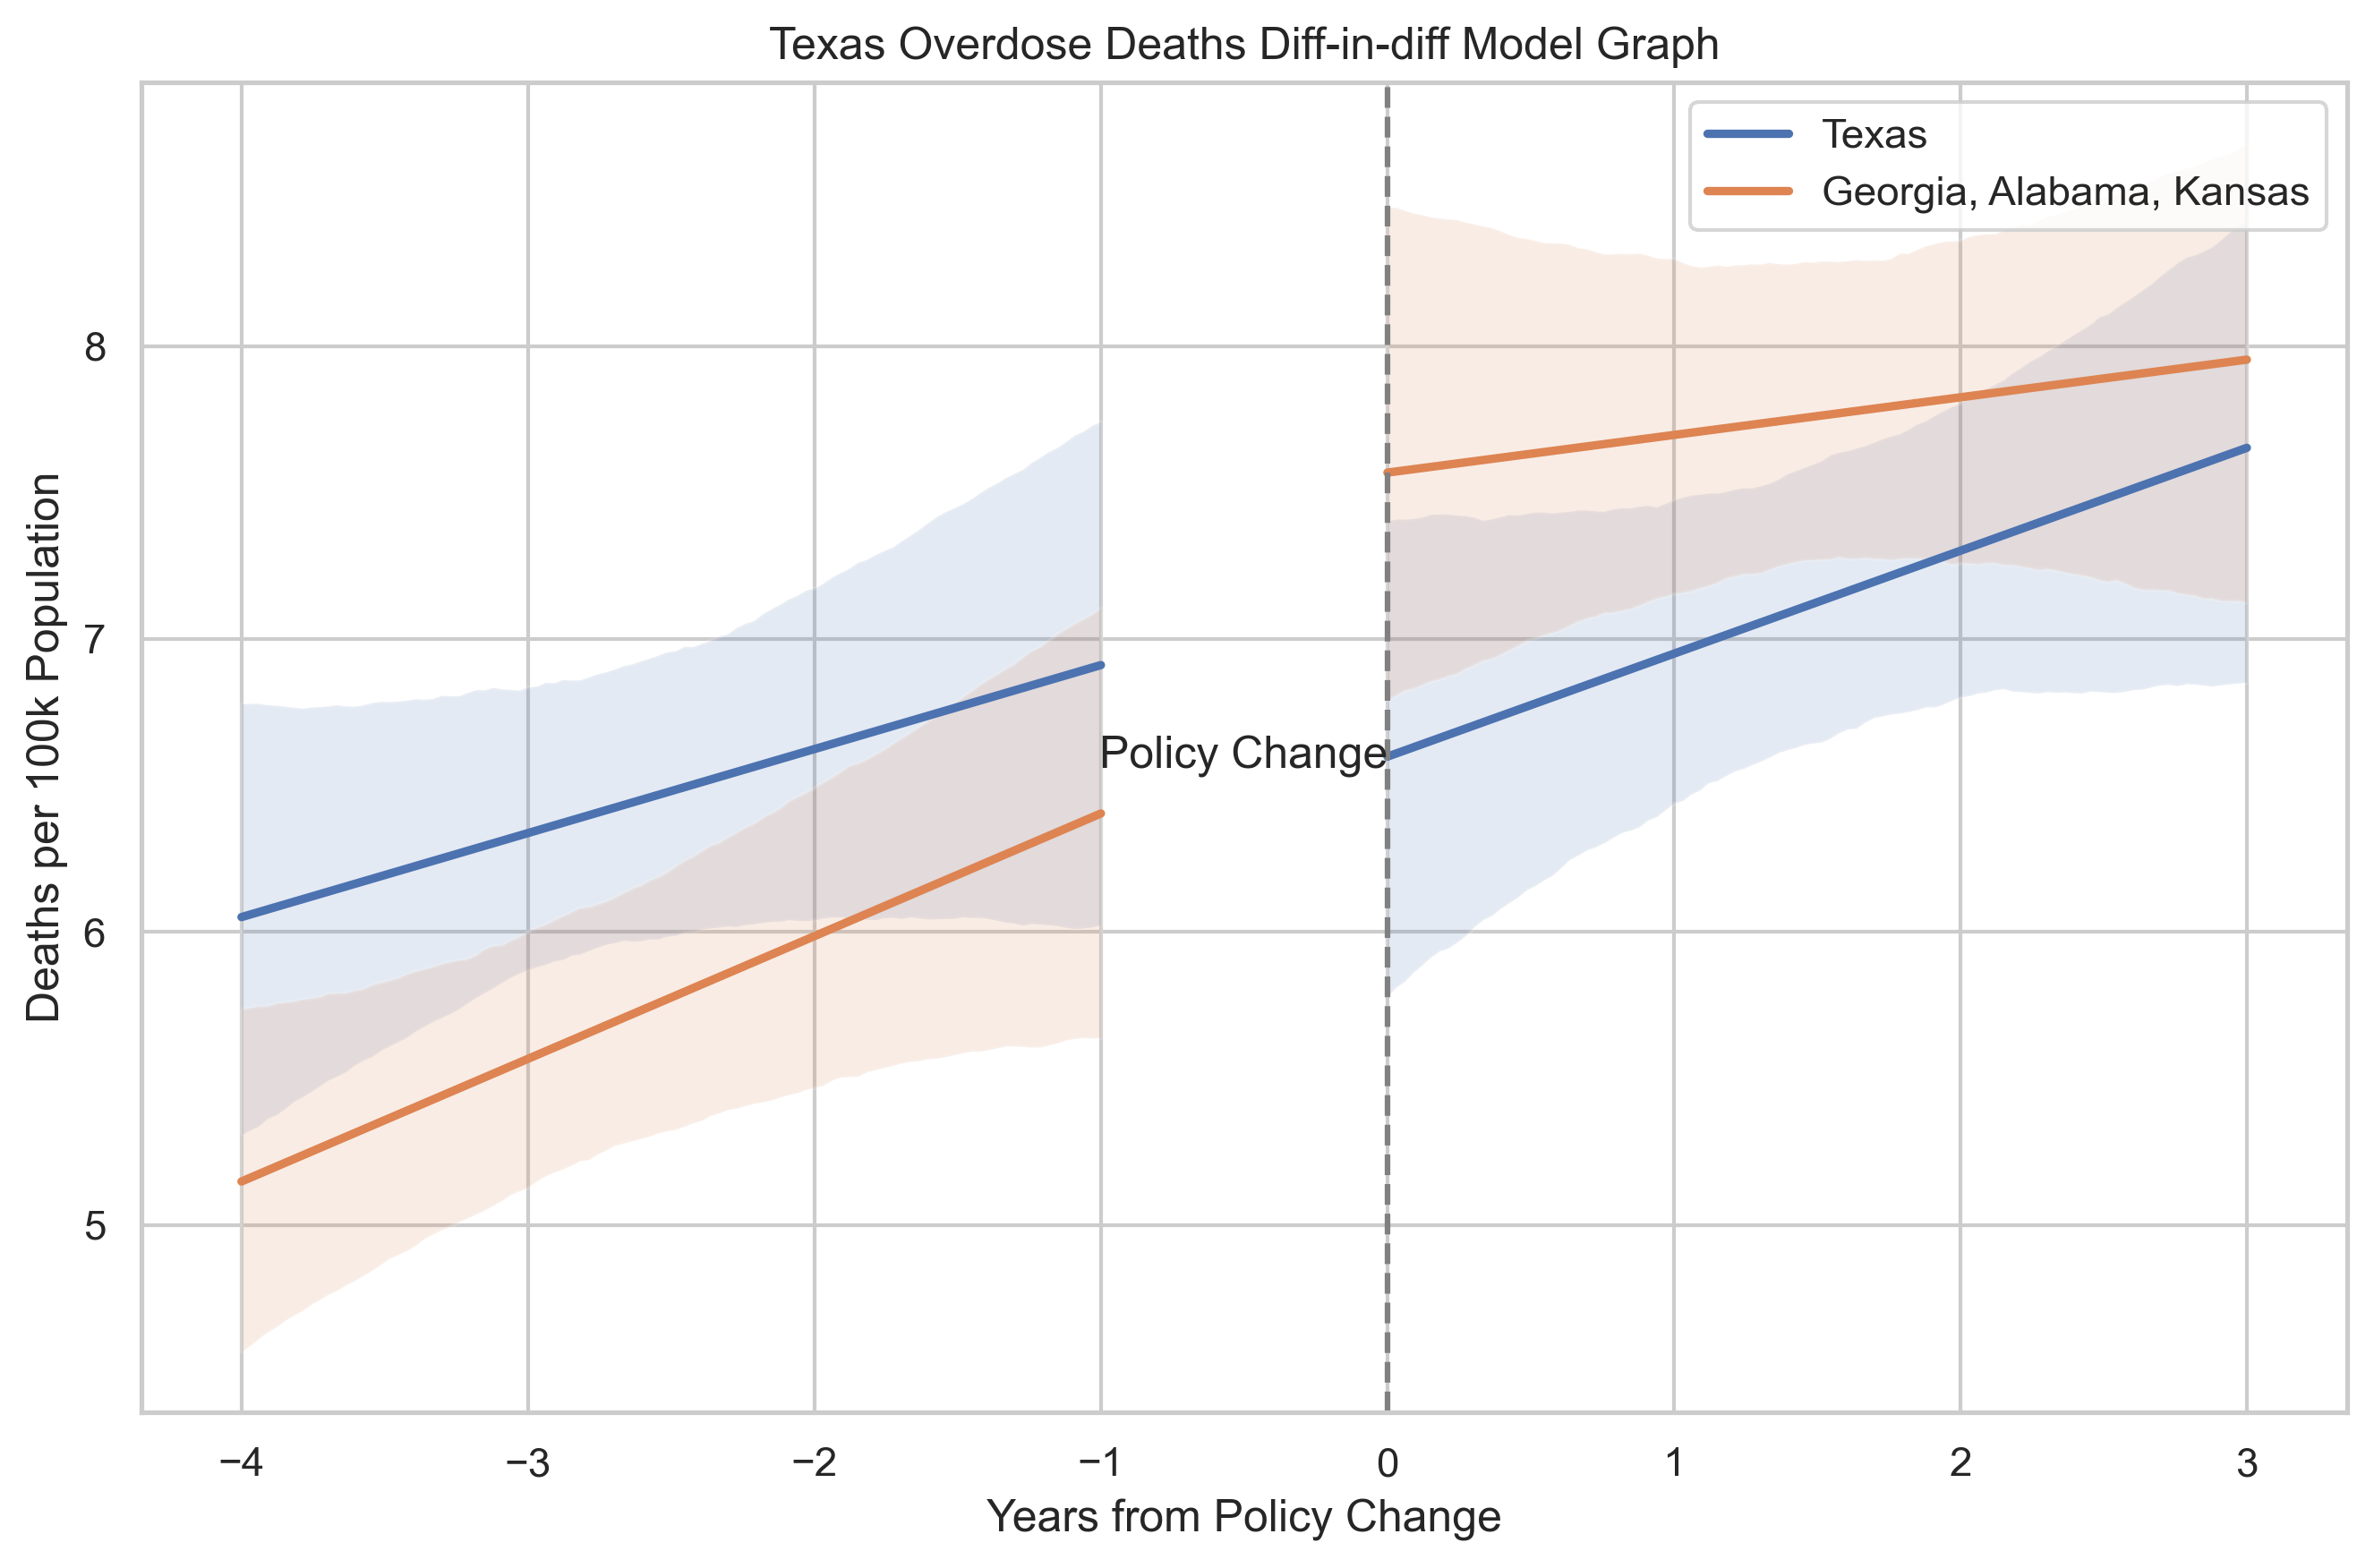

In [10]:
controls = ["Georgia", "Alabama", "Kansas"]
diff_in_diff(tx_df, "Texas", controls)

# Florida

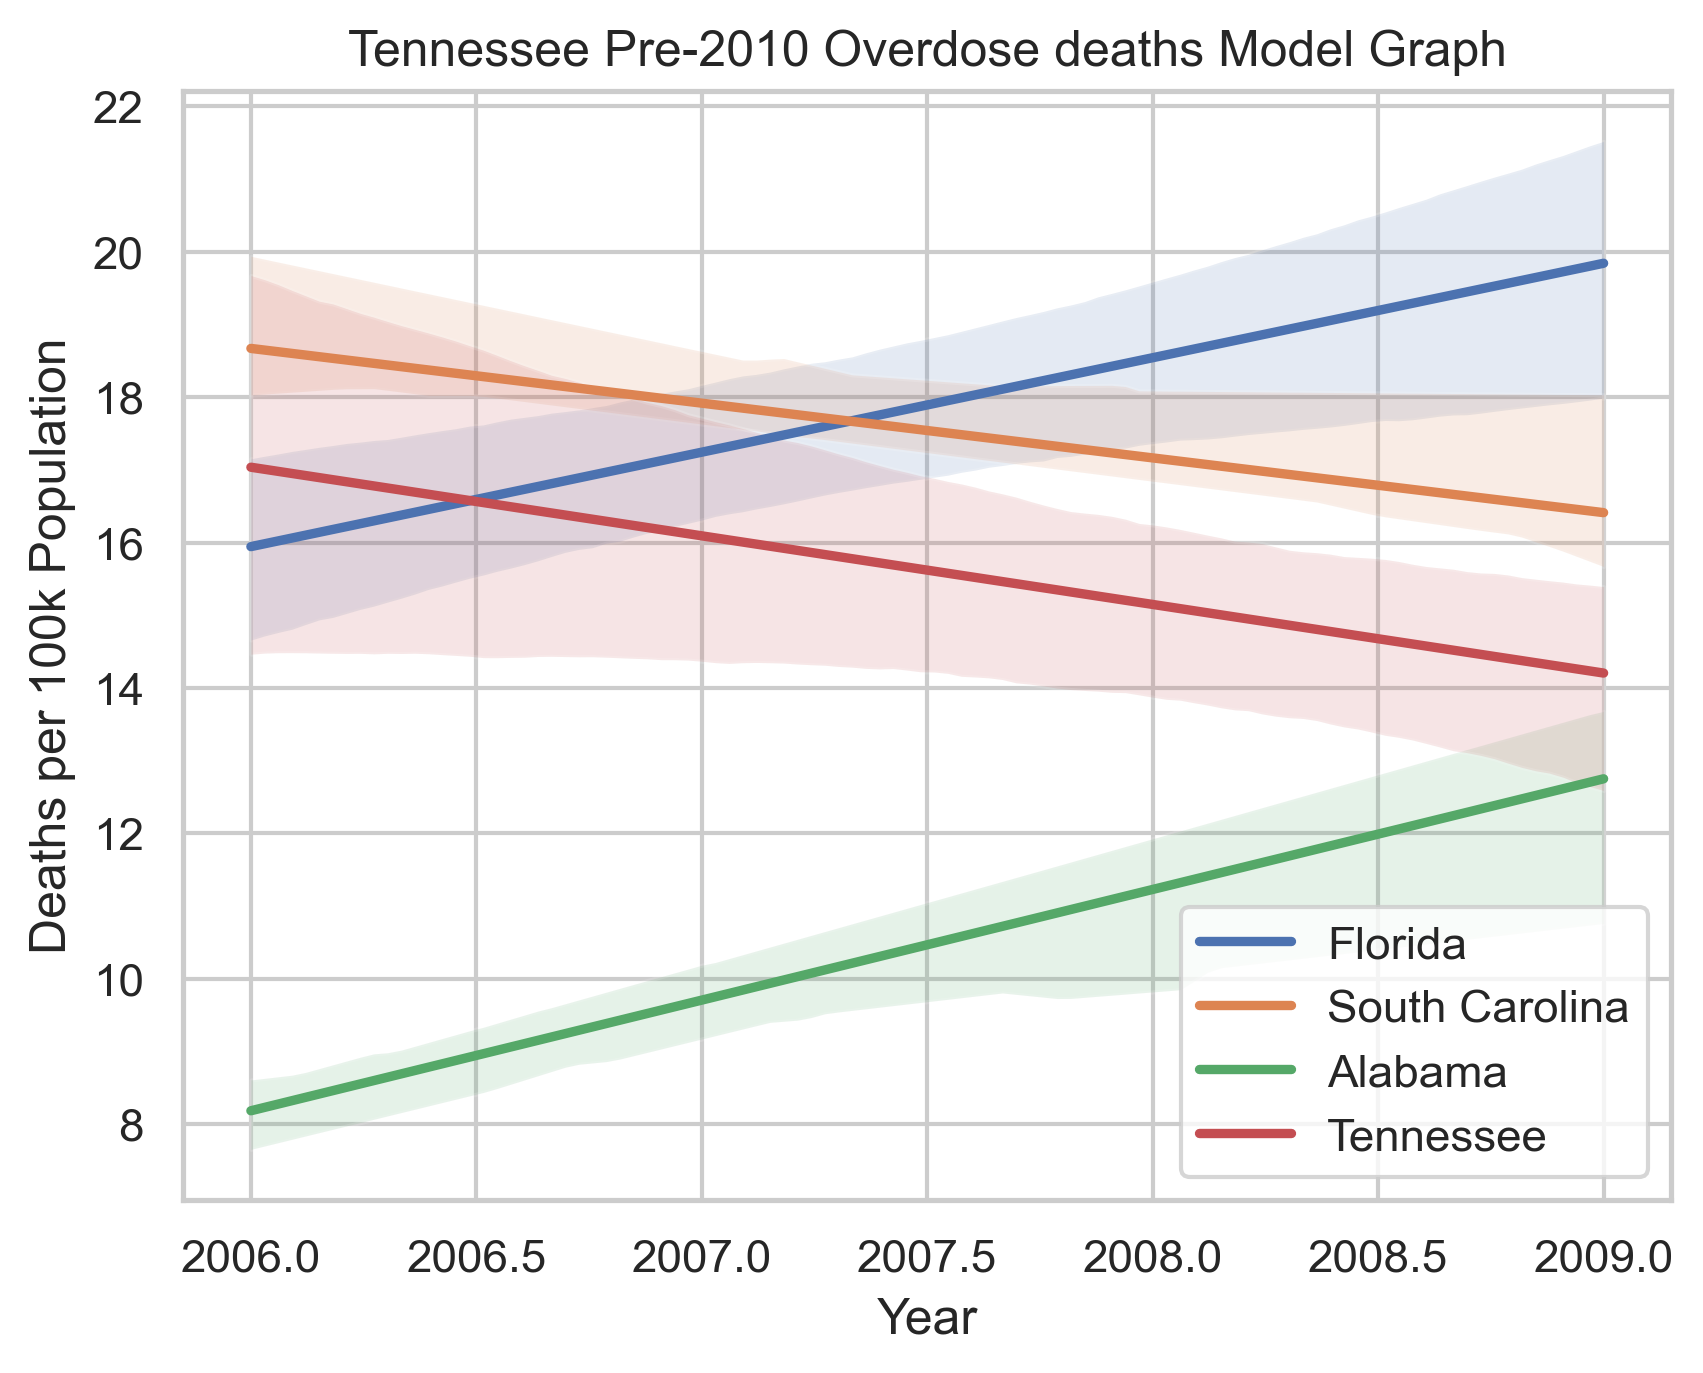

In [11]:
pre(fl_df, "Florida", 2010)
controls = ["South Carolina", "Alabama", "Tennessee"]
for cstate in controls:
    pre(fl_df, cstate, 2010)

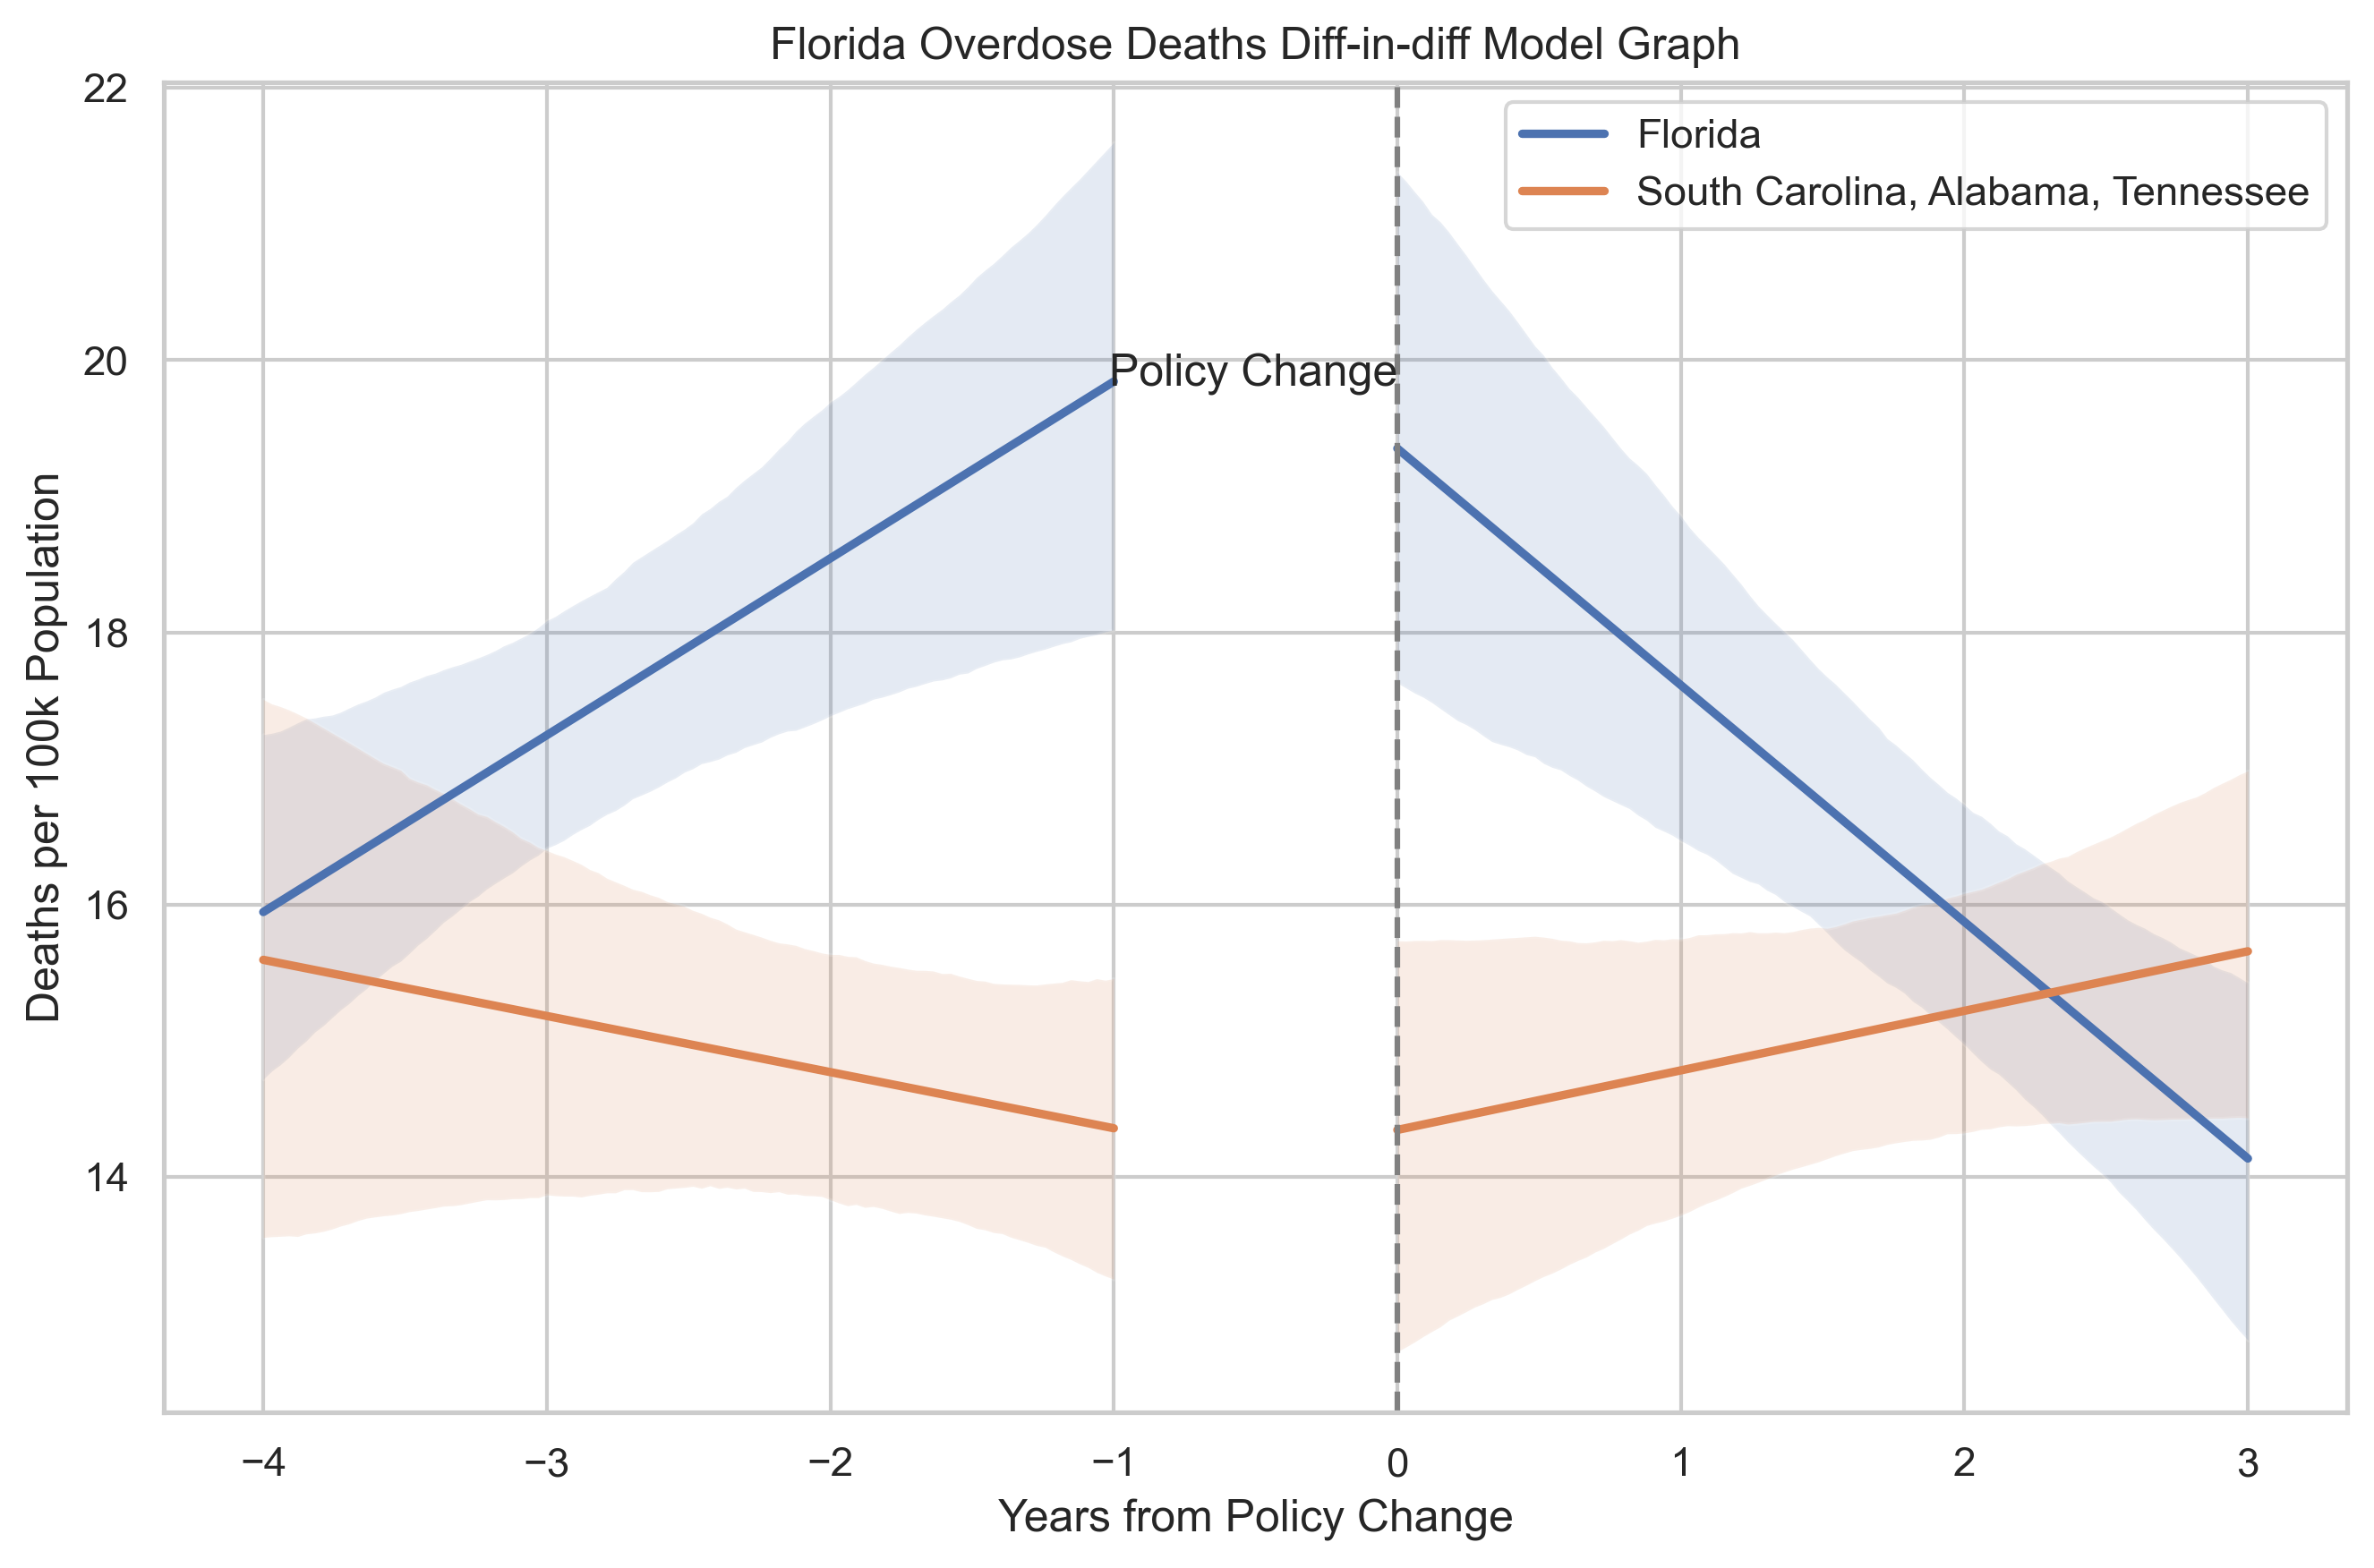

In [12]:
diff_in_diff(fl_df, "Florida", controls)

# Washington

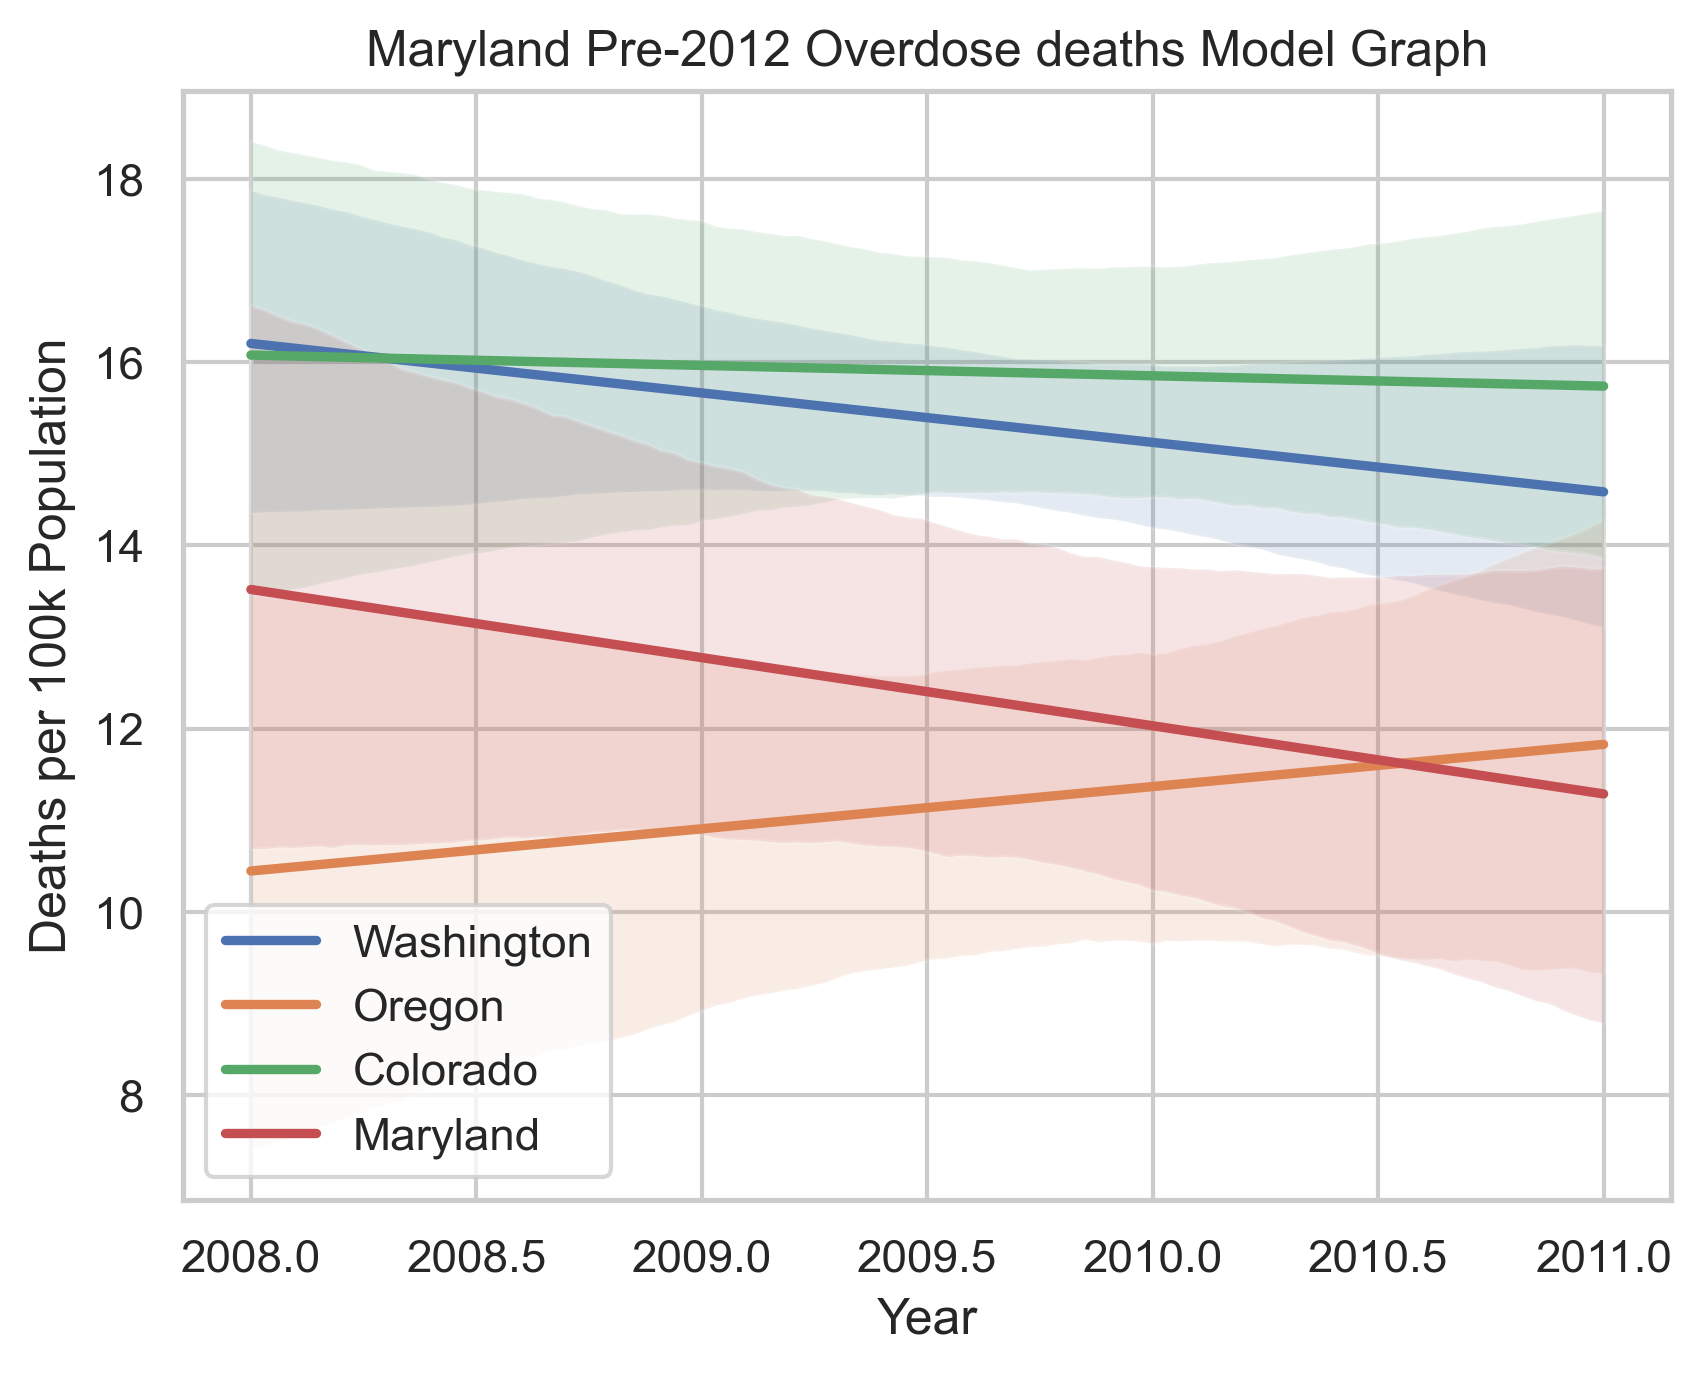

In [13]:
pre(wa_df, "Washington", 2012)
controls = ["Oregon", "Colorado", "Maryland"]
for cstate in controls:
    pre(wa_df, cstate, 2012)

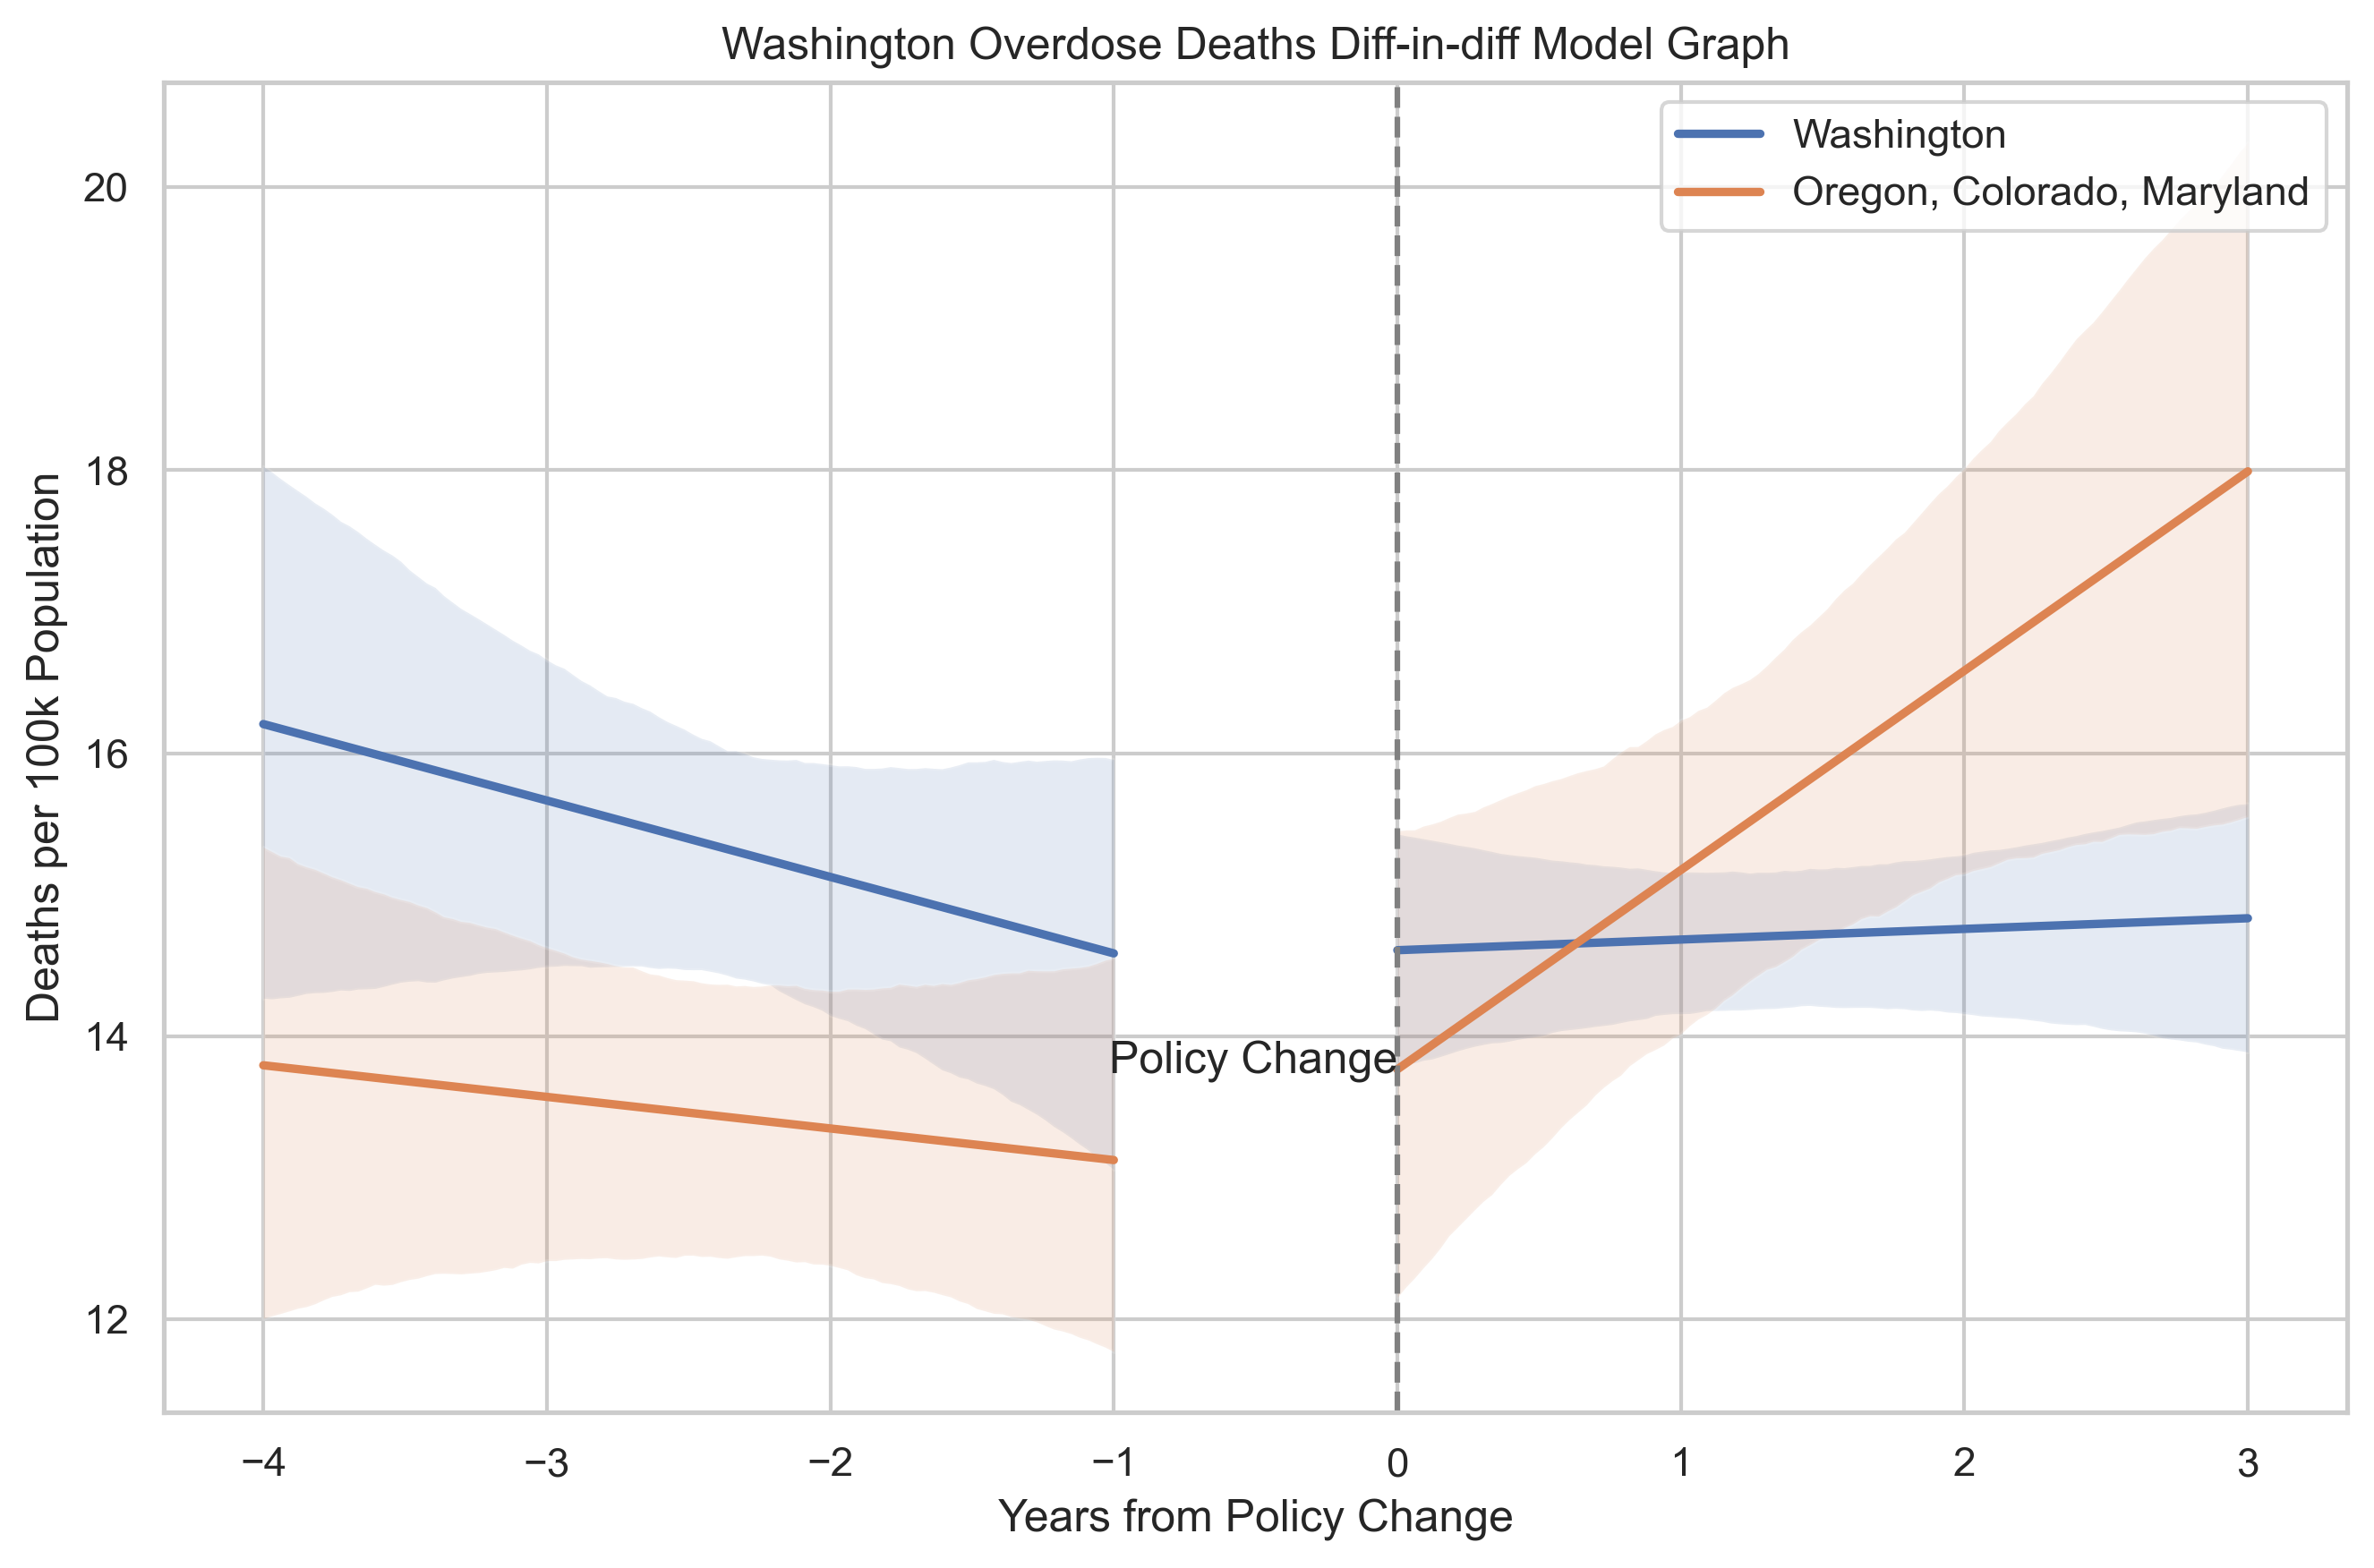

In [14]:
diff_in_diff(wa_df, "Washington", controls)